In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import os
from osgeo import gdal
import sys
import rasterio as rio
import subprocess, glob
%matplotlib inline 
import contextily as ctx
from shapely.ops import split, snap
import shapely
#%matplotlib widget

In [6]:
#Get site boundaries
gdf = gpd.read_file('/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/Project/Data/Site Boundaries/terrestrialSamplingBoundaries.shp')

In [7]:
#Define my sites
sites = ("KONZ", "ORNL", "NIWO", "WREF", "BONA")
mysites = gdf['siteID'].isin(sites)
mysites_gdf = gdf[mysites]
mysites_gdf

,domainNumb,domainName,siteType,siteName,siteID,siteHost,areaKm2,acres,geometry
9,D06,Prairie Peninsula,Core Terrestrial,Konza Prairie Biological Station,KONZ,"The Nature Conservancy, Kansas State Universit...",34.868609,8616.186413,"POLYGON ((-96.61517 39.11102, -96.61467 39.111..."
23,D13,Southern Rockies & Colorado Plateau,Core Terrestrial,Niwot Ridge Mountain Research Station,NIWO,"University of Colorado at Boulder, U.S. Forest...",13.396032,3310.228579,"POLYGON ((-105.59906 40.05762, -105.59909 40.0..."
25,D16,Pacific Northwest,Core Terrestrial,Wind River Experimental Forest,WREF,U.S. Forest Service,41.939962,10363.581085,"MULTIPOLYGON (((-121.93193 45.79103, -121.9268..."
28,D19,Taiga,Core Terrestrial,Caribou-Poker Creeks Research Watershed,BONA,"University of Alaska, Fairbanks",13.929272,3441.984415,"POLYGON ((-147.43979 65.18076, -147.43979 65.1..."
51,D19,Taiga,Core Terrestrial,Caribou-Poker Creeks Research Watershed,BONA,Alaska Department of Natural Resources,35.703951,8822.638540,"POLYGON ((-147.43860 65.20415, -147.43979 65.1..."
55,D07,Appalachian & Cumberland Plateau,Core Terrestrial,Oak Ridge,ORNL,U.S. Department of Energy,57.371094,14176.693613,"MULTIPOLYGON (((-84.33263 35.90912, -84.33132 ..."


In [8]:
#Get Watershed Data
gdf_watershed = gpd.read_file('/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/NEONAquaticWatershed/NEON_Aquatic_Watershed.shp')
gdf_drainage_line = gpd.read_file('/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/NEONAquaticWatershed/NEON_Aquatic_DrainageLine.shp')
gdf_pour_point = gpd.read_file('/Users/Hannah/Downloads/NEON_CO2_Macrosystems_LIDAR/NEONAquaticWatershed/NEON_Aquatic_PourPoint.shp')

In [9]:
#Limit to our sites
water_sites = ("KING", "COMO", "CARI", "MART")
gdf_watershed = gdf_watershed[gdf_watershed['SiteID'].isin(water_sites)]
gdf_drainage_line = gdf_drainage_line[gdf_drainage_line['SiteID'].isin(water_sites)]
gdf_pour_point = gdf_pour_point[gdf_pour_point['SiteID'].isin(water_sites)]
gdf_drainage_line['siteID'] = ('BONA', 'NIWO', 'KONZ', 'MART')
gdf_watershed['siteID'] = water_sites

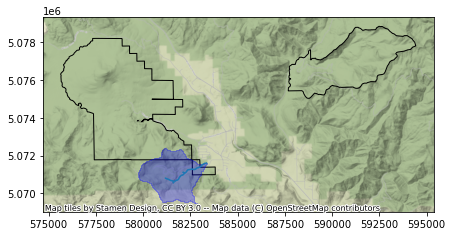

In [10]:
#Plot WA site and define WA variables
WREF = mysites_gdf[mysites_gdf['siteID'] == 'WREF']
MART_watershed = gdf_watershed[gdf_watershed['SiteID'] == 'MART']
MART_drain = gdf_drainage_line[gdf_drainage_line['SiteID'] == 'MART']
WREF = WREF.to_crs("EPSG:32610")
MART_watershed = MART_watershed.to_crs("EPSG:32610")
WREF = WREF.to_crs("EPSG:32610")
MART_drain = MART_drain.to_crs("EPSG:32610")
f, ax = plt.subplots(figsize=(7,7))
WREF.plot(ax=ax, facecolor='none', edgecolor='k');
MART_watershed.plot(ax=ax, facecolor='blue', edgecolor='blue', alpha = 0.3); 
MART_drain.plot(ax=ax);
ctx.add_basemap(ax=ax, crs=MART_watershed.crs, source=ctx.providers.Stamen.Terrain, zoom=14);

In [12]:
#Add in sensor locations
df = pd.read_csv("/Users/Hannah/Documents/UW/NEON/NEON Sites/Sensor_Positions.csv")
sensor_location = gpd.GeoDataFrame(df.drop(['Long', 'Lat'], axis=1),
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(df.Long, df.Lat)])

/Users/Hannah/miniconda3/envs/uwgda2021/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [29]:
sensor_location

,Description,Elevation,geometry
0,Martha Creek Water Chemistry and Temperature S1,348.45,POINT (-121.93395 45.79079)
1,Martha Creek Water Chemistry and Temperature S2,337.13,POINT (-121.92942 45.79232)


In [13]:
#Convert to correct crs upstream downstream
sensor_location = sensor_location.to_crs('EPSG:32610')

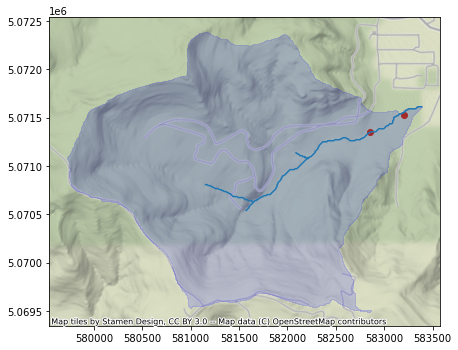

In [14]:
#Plot watershed with sensor points
WREF = mysites_gdf[mysites_gdf['siteID'] == 'WREF']
MART_watershed = gdf_watershed[gdf_watershed['SiteID'] == 'MART']
MART_drain = gdf_drainage_line[gdf_drainage_line['SiteID'] == 'MART']
MART_watershed = MART_watershed.to_crs("EPSG:32610")
WREF = WREF.to_crs("EPSG:32610")
MART_drain = MART_drain.to_crs("EPSG:32610")
f, ax = plt.subplots(figsize=(7,7))
#WREF.plot(ax=ax, facecolor='none', edgecolor='k');
MART_watershed.plot(ax=ax, facecolor='blue', edgecolor='blue', alpha = 0.15); 
MART_drain.plot(ax=ax);
sensor_location.plot(ax=ax, facecolor = "brown");
#Add basemap, specifying crs keyword
ctx.add_basemap(ax=ax, crs=MART_watershed.crs, source=ctx.providers.Stamen.Terrain, zoom=14, alpha= 0.8);

In [18]:
point1 = sensor_location[sensor_location['Elevation'] == 348.45]
point2 = sensor_location[sensor_location['Elevation'] == 337.13]

In [19]:
line = MART_drain.geometry.unary_union

In [20]:
#Snap points to line
result = sensor_location.copy()
result['geometry'] = result.apply(lambda row: line.interpolate(line.project( row.geometry)), axis=1)

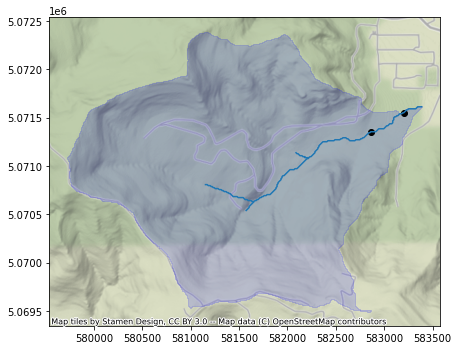

In [21]:
f, ax = plt.subplots(figsize=(7,7))
#WREF.plot(ax=ax, facecolor='none', edgecolor='k');
MART_watershed.plot(ax=ax, facecolor='blue', edgecolor='blue', alpha = 0.15); 
MART_drain.plot(ax=ax);
result.plot(ax=ax, facecolor = "black");
#Add basemap, specifying crs keyword
ctx.add_basemap(ax=ax, crs=MART_watershed.crs, source=ctx.providers.Stamen.Terrain, zoom=14, alpha= 0.8);

In [284]:
coords = result.geometry.unary_union
point2 = Point((583202.471, 5071549.829))
point1 = Point((582860.351, 5071352.011))

In [325]:
entire_stream_length = split(line,point2).length
print("The stream length is", round(entire_stream_length,2), "meters")

The stream length is 3134.31 meters


In [26]:
from shapely.geometry import MultiPoint
from shapely.geometry import LineString
from shapely import geometry, ops
def get_linesegments(line, n): 
     points = MultiPoint([line.interpolate(i/n, normalized=True) for i in range(1, n)])
     return line.difference(points.buffer(1e-13))

In [359]:
#Function to fix precision issues 
def stream_length(point, line):
    ### Create a buffer polygon around the interpolated point
    buff = point.buffer(10)
    #Split line around buffer
    split_line = split(line,buff)
    segments = [feature for feature in split_line]
    gdf_segments = gpd.GeoDataFrame(
        list(range(len(segments))), geometry=segments)
    gdf_segments.columns = ['index', 'geometry']

    return gdf_segments

In [327]:
sensor1 = stream_length(point1, line)
sensor2 = stream_length(point2, line)

Length above upstream sensor is 2467.66 meters


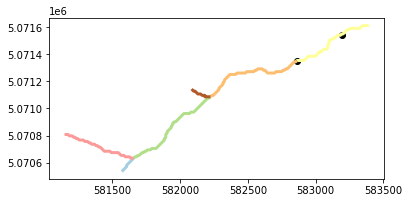

In [328]:
fig, ax = plt.subplots()
sensor1.plot(ax=ax, column='index', lw=3, cmap='Paired')
result.plot(ax=ax, facecolor = "black");
print("Length above upstream sensor is", round(entire_stream_length - sensor1.length[5],2), "meters")

Length above upstream sensor is 2915.87 meters


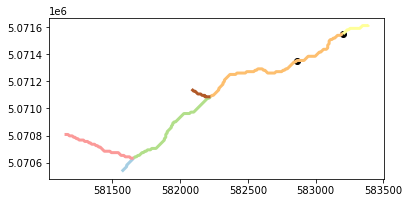

In [287]:
fig, ax = plt.subplots()
sensor2.plot(ax=ax, column='index', lw=3, cmap='Paired')
result.plot(ax=ax, facecolor = "black");
print("Length above upstream sensor is", round(entire_stream_length - sensor2.length[5],2), "meters")

In [288]:
print("Length between sensors is", round(sensor1.length[5] - sensor2.length[5],2), "meters")

Length between sensors is 448.21 meters


In [289]:
#Get DNR derived stream
dnr = gpd.read_file("/Users/Hannah/Downloads/wind river streams/Wind_RS_hydro.shp")
dnr = dnr.to_crs("EPSG:32610")
intersections = gpd.overlay(pol1, dnr, how='intersection', keep_geom_type=False)

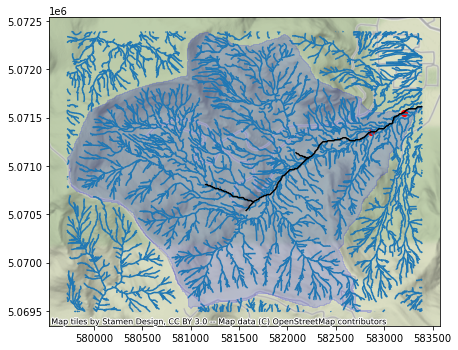

In [315]:
#Plot of dnr derived stream
f, ax = plt.subplots(figsize=(7,7))
intersections.plot(ax=ax)
MART_watershed.plot(ax=ax, facecolor='blue', edgecolor='blue', alpha = 0.15); 
MART_drain.plot(ax=ax, color = 'black');
result.plot(ax=ax, facecolor = "red");
#Add basemap, specifying crs keyword
ctx.add_basemap(ax=ax, crs=MART_watershed.crs, source=ctx.providers.Stamen.Terrain, zoom=14, alpha= 0.8);

## DEM derived stream

In [282]:
#Derived stream from WA DNR DEM map using ArcMap - this file is the result of this 
stream34 = gpd.read_file('/Users/Hannah/OneDrive - UW/NEON Data/Spatial Data/StreamOrder/Stream_34_clip.shp')
stream34 = stream34.to_crs("EPSG:32610")

Stream Derived from DEM


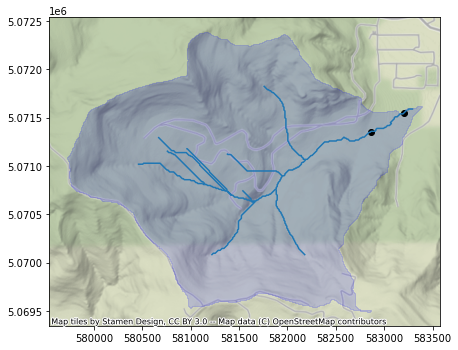

In [283]:
f, ax = plt.subplots(figsize=(7,7))
#WREF.plot(ax=ax, facecolor='none', edgecolor='k');
MART_watershed.plot(ax=ax, facecolor='blue', edgecolor='blue', alpha = 0.15); 
stream34.plot(ax=ax);
result.plot(ax=ax, facecolor = "black");
#Add basemap, specifying crs keyword
ctx.add_basemap(ax=ax, crs=MART_watershed.crs, source=ctx.providers.Stamen.Terrain, zoom=14, alpha= 0.8);
print("Stream Derived from DEM")

In [37]:
print("The length of the stream (orders 3 and 4) derived from DEM is", stream34['Length'].sum(), "meters.")

The length of the stream (orders 3 and 4) derived from DEM is 9088 meters.


In [363]:
stream34_length = stream34['Length'].sum()

In [331]:
line34 = stream34.geometry.unary_union

In [360]:
sensor1_dem = stream_length(point1, line34)
sensor2_dem = stream_length(point2, line34)

Length above upstream sensor is 8600.27 meters


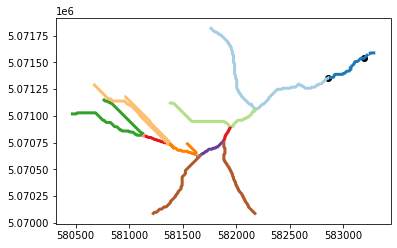

In [379]:
fig, ax = plt.subplots()
sensor1_dem.plot(ax=ax, lw=3, cmap='Paired')
result.plot(ax=ax, facecolor = "black");
print("Length above upstream sensor is", round(stream34_length - sensor1_dem.length[3],2), "meters")

Length above upstream sensor is 9068.75 meters


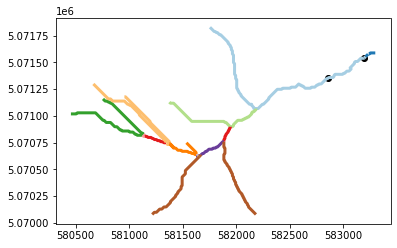

In [383]:
fig, ax = plt.subplots()
sensor2_dem.plot(ax=ax, lw=3, cmap='Paired')
result.plot(ax=ax, facecolor = "black");
print("Length above upstream sensor is", round(stream34_length - sensor2_dem.length[2],2), "meters")

In [358]:
test = sensor1_dem.loc[[1],'geometry']
test.distance(point1) < 10

1    True
dtype: bool

## Elevation of Stream

In [64]:
from osgeo import gdal
from osgeo import ogr
# raster dem10m
file = '/Users/Hannah/OneDrive - UW/NEON Data/Spatial Data/f625.tif'
layer = gdal.Open(file)
gt =layer.GetGeoTransform()
bands = layer.RasterCount
print(bands)
print(gt)

1
(577605.0, 10.0, 0.0, 5080555.0, 0.0, -10.0)


In [59]:
x,y  = (582860.351, 5071352.011)
# transform to raster point coordinates
rasterx = int((x - gt[0]) / gt[1])
rastery = int((y - gt[3]) / gt[5])
# only one band here
print(layer.GetRasterBand(1).ReadAsArray(rasterx,rastery, 1, 1))

[[1310.]]


In [61]:
def Val_raster(x,y,layer,bands,gt):
    col=[]
    px = int((x - gt[0]) / gt[1])
    py =int((y - gt[3]) / gt[5])
    for j in range(bands):
        band = layer.GetRasterBand(j+1)
        data = band.ReadAsArray(px,py, 1, 1)
        col.append(data[0][0])
    return col

In [266]:
# creation of an empty ogr linestring to handle all possible segments of a line with  Union (combining the segements)
profilogr = ogr.Geometry(ogr.wkbLineString)
# open the profile shapefile
#source = ogr.Open('/Users/Hannah/OneDrive - UW/NEON Data/Spatial Data/Stream_Network/MART_drain.shp')
source = ogr.Open('/Users/Hannah/OneDrive - UW/NEON Data/Spatial Data/StreamOrder/Stream_34_clip.shp')
cshp = source.GetLayer()
# union the segments of the line
for element in cshp:
    geom =element.GetGeometryRef()
    profilogr = profilogr.Union(geom)

In [267]:
from shapely.wkb import loads
# transformation in Shapely geometry
profilshp = loads(profilogr.ExportToWkb())
# creation the equidistant points on the line with a step of 20m
lenght=int(profilshp.length)
x = []
y = []
z = []
# distance of the topographic profile
distance = []
for currentdistance  in range(0,lenght,lenght//100):
# creation of the point on the line
    point = profilshp.interpolate(currentdistance)
    xp,yp=point.x, point.y
    x.append(xp)
    y.append(yp)
    # extraction of the elevation value from the MNT
    z.append(Val_raster(xp,yp,layer,bands,gt)[0])
    distance.append(currentdistance)

In [268]:
def closest(list, Number):
    aux = []
    for valor in list:
        aux.append(abs(Number-valor))
    return aux.index(min(aux))

In [271]:
j = closest(x,583202.471)

In [270]:
k = closest(x,582860.351)

In [277]:
distance.reverse()

<ipython-input-280-d48965b8eeeb>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Pink dots are sensor locations


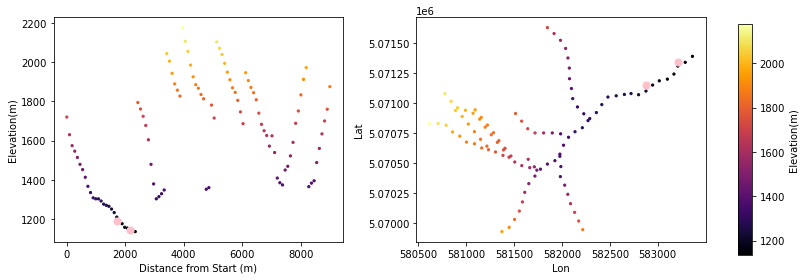

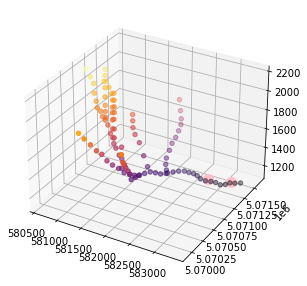

In [280]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
#ax1
im = ax1.scatter(distance,z,c=z, s=5, cmap = 'inferno');
#fig.colorbar(ax1); 
ax1.scatter(distance[j],z[j+1], s = 50, c = 'pink');
ax1.scatter(distance[k],z[k+1], s = 50, c = 'pink');
#cbar.set_label('Elevation (m)')
#plt.xlabel("Distance from Source(m)")
#plt.ylabel("Elevation (m)");
ax1.set(xlabel = "Distance from Start (m)",
       ylabel = "Elevation(m)") 

#ax2
ax2.scatter(x,y,c=z, s=5, cmap = 'inferno');
ax2.scatter(x[j],y[j+1], s = 50, c = 'pink');
ax2.scatter(x[k],y[k+1], s = 50, c = 'pink');
ax2.set(xlabel = "Lon",
       ylabel = "Lat") 

#colorbar
cb_ax = fig.add_axes([1.03, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Elevation(m)')

plt.tight_layout()

print("Pink dots are sensor locations")

fig = plt.figure(figsize = (20,5))
ax = plt.axes(projection="3d")
ax.scatter3D(x, y, z, c=z, cmap='inferno');
ax.scatter3D(x[j],y[j+1],z[j], s = 100, c = 'pink')
ax.scatter3D(x[k],y[k+1],z[k], s = 100, c = 'pink')
plt.show()